# Café Sales Data Cleaning

**Objective:** Clean and validate raw café transaction data in preparation for exploratory analysis and modeling.

**Dataset:** 10,000 transactions — fields include Transaction ID, Item, Quantity, Price Per Unit, Total Spent, Payment Method, Location, and Transaction Date.
**Tools:** Python (Pandas, NumPy, Matplotlib)
**Key Deliverables:**
- Fully cleaned dataset (`cleaned_cafe_sales.csv`) ready for EDA
- Missing value treatment and logical imputation for numerical columns
- Standardized categorical fields and capitalization
- Validation ensuring data consistency and completeness

---

## Table of Contents
1. [Initial Impressions](#initial-impressions)
2. [Duplicates](#duplicates)
3. [Missing Values](#missing-values)
4. [Filling Categorical Missing Values](#filling-categorical-missing-values)
5. [Normalizing Capitalization](#normalizing-capitalization)
6. [Filling Numerical Missing Values](#filling-numerical-missing-values)
7. [Calculating Missing Numerical Values Based on Relationships](#relationship-imputation)
8. [Catching Remaining Missing Numerical Values with Column Means](#final-numeric-impute)
9. [Validation and Visualization](#validation)
10. [Data Quality Summary](#dqs)
11. [Exporting Cleaned Data](#exports)


---

## Imports and Utils

In [ ]:
import pandas as pd
import numpy as np
import os

data = pd.read_csv('dirty_cafe_sales.csv')
data.head(11)


,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,TXN_1961373,Coffee,2,2.0,4.0,Credit Card,Takeaway,2023-09-08
1,TXN_4977031,Cake,4,3.0,12.0,Cash,In-store,2023-05-16
2,TXN_4271903,Cookie,4,1.0,ERROR,Credit Card,In-store,2023-07-19
3,TXN_7034554,Salad,2,5.0,10.0,UNKNOWN,UNKNOWN,2023-04-27
4,TXN_3160411,Coffee,2,2.0,4.0,Digital Wallet,In-store,2023-06-11
5,TXN_2602893,Smoothie,5,4.0,20.0,Credit Card,NaN,2023-03-31
6,TXN_4433211,UNKNOWN,3,3.0,9.0,ERROR,Takeaway,2023-10-06
7,TXN_6699534,Sandwich,4,4.0,16.0,Cash,UNKNOWN,2023-10-28
8,TXN_4717867,NaN,5,3.0,15.0,NaN,Takeaway,2023-07-28
9,TXN_2064365,Sandwich,5,4.0,20.0,NaN,In-store,2023-12-31


---

<a id='initial-impressions'></a>

## Initial Impressions
- All dtypes are 'object'; indicates conversion may be necessary for columns that should be numeric.
- Transaction ID shows 10000/10000 non-null objects — for the purposes of cleaning, this column will be ignored.
- Other columns show many missing values.
- Dataset is smaller than I had initially guessed based on the file size (10,000 rows vs ~1MB file size).

In [17]:
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 9540 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Transaction ID    9540 non-null   object        
 1   Item              9540 non-null   object        
 2   Quantity          9540 non-null   float64       
 3   Price Per Unit    9540 non-null   float64       
 4   Total Spent       9540 non-null   float64       
 5   Payment Method    9540 non-null   object        
 6   Location          9540 non-null   object        
 7   Transaction Date  9540 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(3), object(4)
memory usage: 521.7+ KB


---

## Duplicates
<a id='duplicates'></a>

In [ ]:
# Checking for duplicates, specifically in 'Transaction ID'
data['Transaction ID'].duplicated().sum() # This column serves as a unique identifier; duplicate values indicate redundant rows.


0

---

## Missing Values
<a id='missing-values'></a>

In [ ]:
# Checking missing values
data.isnull().sum()


Transaction ID         0
Item                 333
Quantity             138
Price Per Unit       179
Total Spent          173
Payment Method      2579
Location            3265
Transaction Date     159
dtype: int64

In [ ]:
# Summary of missing values
print(
    f"{data.isnull().sum().sum()} missing values "
    f"({round((data.isnull().sum().sum() / (data.shape[0]*data.shape[1]))*100, 2)}% of total)"
)

# ~8.5% missing values is low enough that dropping missing rows is a safe option.
# However, distribution of missing values is an important factor to consider for analyses.
# I will check missingness distribution even though this project does not focus on analysis.


6826 missing values (8.53% of total)


In [ ]:
# Checking missing values distribution
data.isnull().sum().sort_values(ascending=False)


Location            3265
Payment Method      2579
Item                 333
Price Per Unit       179
Total Spent          173
Transaction Date     159
Quantity             138
Transaction ID         0
dtype: int64

---

## Filling Categorical Missing Values
<a id='filling-categorical-missing-values'></a>

In [ ]:
# Fill missing categorical values with 'Unknown' — these represent cases where data was not captured.
data[['Payment Method', 'Location', 'Item']] = data[['Payment Method', 'Location', 'Item']].fillna('Unknown')


---

## Normalizing Capitalization
<a id='normalizing-capitalization'></a>

In [ ]:
# Clean category formatting for consistency.
for col in ['Item', 'Payment Method', 'Location']:
    data[col] = data[col].astype(str).str.strip().str.title()


---

## Filling Numerical Missing Values
<a id='filling-numerical-missing-values'></a>

In [ ]:
# Converting numeric columns from 'object' to numeric
for col in ['Quantity', 'Price Per Unit', 'Total Spent']:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Convert 'Transaction Date' to datetime
data['Transaction Date'] = pd.to_datetime(data['Transaction Date'], errors='coerce')

# Drop rows where Transaction Date is still missing.
# Justification:
#   - Less than 5% of rows have missing dates.
#   - The missingness is random and does not appear concentrated in any specific category.
#   - Since Transaction Date is essential for chronological analysis, dropping these rows prevents skewed time-based metrics.
data.dropna(subset=['Transaction Date'], inplace=True)


---

## Calculating Missing Numerical Values Based on Relationships
<a id='relationship-imputation'></a>

In [ ]:
# Total Spent = Quantity * Price Per Unit (inherent relationship)
# If Quantity and Price Per Unit are known:
mask = data['Total Spent'].isna() & data['Quantity'].notna() & data['Price Per Unit'].notna()
data.loc[mask, 'Total Spent'] = data.loc[mask, 'Quantity'] * data.loc[mask, 'Price Per Unit']

# If Total Spent and Quantity are known:
mask = data['Price Per Unit'].isna() & data['Total Spent'].notna() & data['Quantity'].notna() & (data['Quantity'] != 0)
data.loc[mask, 'Price Per Unit'] = data.loc[mask, 'Total Spent'] / data.loc[mask, 'Quantity']

# If Total Spent and Price Per Unit are known:
mask = data['Quantity'].isna() & data['Total Spent'].notna() & data['Price Per Unit'].notna() & (data['Price Per Unit'] != 0)
data.loc[mask, 'Quantity'] = data.loc[mask, 'Total Spent'] / data.loc[mask, 'Price Per Unit']


---

## Catching Remaining Missing Numerical Values with Column Means
<a id='final-numeric-impute'></a>

In [ ]:
# For any remaining missing numeric values, fill with the mean of the respective column.
for col in ['Quantity', 'Price Per Unit', 'Total Spent']:
    mean_value = data[col].mean()
    data[col].fillna(mean_value, inplace=True)


---

<a id='validation'></a>

## Validation


In [ ]:
# Check whether Total Spent ≈ Quantity × Price Per Unit
check = (data['Total Spent'].round(2) == (data['Quantity'] * data['Price Per Unit']).round(2))
print(f"Rows consistent: {check.mean() * 100:.2f}%")


Rows consistent: 99.42%


In [ ]:
# Confirm remaining missing values
data.isnull().sum().sort_values(ascending=False)


Transaction ID      0
Item                0
Quantity            0
Price Per Unit      0
Total Spent         0
Payment Method      0
Location            0
Transaction Date    0
dtype: int64

Cleaned shape: (9540, 8)

Remaining missing values: 0
All missing values successfully handled.

Numeric Summary


,count,mean,std,min,25%,50%,75%,max
Quantity,9540.0,3.021991,1.417191,1.0,2.0,3.0,4.0,5.0
Price Per Unit,9540.0,2.949290,1.276591,1.0,2.0,3.0,4.0,5.0
Total Spent,9540.0,8.923955,5.993137,1.0,4.0,8.0,12.0,25.0



Categorical Summary


,count,unique,top,freq
Transaction ID,9540,9540,TXN_1961373,1
Item,9540,10,Juice,1124
Payment Method,9540,5,Unknown,2719
Location,9540,4,Unknown,3438



Date Summary
Transaction date range: 2023-01-01 → 2023-12-31


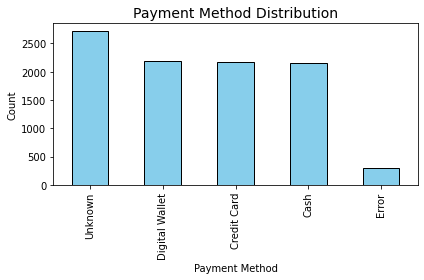

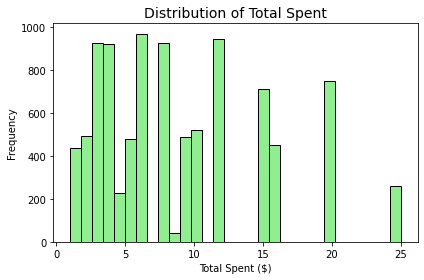

In [18]:
# Post-cleaning and visual plots

import matplotlib.pyplot as plt

# Dataset shape and missing check
print(f"Cleaned shape: {data.shape}")

missing_total = data.isna().sum().sum()
print(f"\nRemaining missing values: {missing_total}")
if missing_total == 0:
    print("All missing values successfully handled.")

# Separate descriptors for numeric, categorical, and datetime values
print("\nNumeric Summary")
display(data.describe(include=[np.number]).T)

print("\nCategorical Summary")
display(data.describe(include=['object']).T)

print("\nDate Summary")
date_min = data['Transaction Date'].min()
date_max = data['Transaction Date'].max()
print(f"Transaction date range: {date_min.date()} → {date_max.date()}")

# Visualization 1: Payment Method distribution
plt.figure(figsize=(6,4))
data['Payment Method'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Payment Method Distribution', fontsize=14)
plt.xlabel('Payment Method')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Visualization 2: Total Spent histogram
plt.figure(figsize=(6,4))
plt.hist(data['Total Spent'], bins=30, edgecolor='black', color='lightgreen')
plt.title('Distribution of Total Spent', fontsize=14)
plt.xlabel('Total Spent ($)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

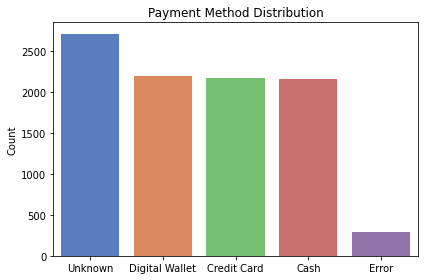

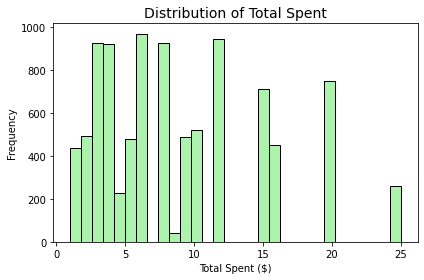

In [ ]:
# Alternative visualizations using seaborn

import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(x='Payment Method', data=data, order=data['Payment Method'].value_counts().index, palette='muted')
plt.title('Payment Method Distribution')
plt.xlabel('')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
sns.histplot(data['Total Spent'], bins=30, edgecolor='black', color='lightgreen')
plt.title('Distribution of Total Spent', fontsize=14)
plt.xlabel('Total Spent ($)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


## Final Validation Summary

- All missing and invalid values were successfully handled
- Numerical fields (`Quantity`, `Price Per Unit`, `Total Spent`) validated for internal consistency (`Total Spent ≈ Quantity × Price`)
- Transaction dates verified to span the full 2023 calendar year
- The cleaned dataset now supports robust exploratory analysis and visualization
- Exported as `cleaned_cafe_sales.csv` for downstream analysis


---

<a id='dqs'></a>

## Data Quality Summary

In [ ]:
# Data Quality Summary
summary = pd.DataFrame({
    'Metric': ['Initial Missing %', 'Remaining Missing %', 'Duplicate Rows', 'Rows After Cleaning'],
    'Value': ['8.5%', f"{data.isna().sum().sum() / (data.size):.2%}", 0, len(data)]
})
display(summary)

,Metric,Value
0,Initial Missing %,8.5%
1,Remaining Missing %,0.00%
2,Duplicate Rows,0
3,Rows After Cleaning,9540


---

<a id='exports'></a>

## Exports

In [ ]:
# Exporting cleaned data to csv. It helps me to have a visual reference of the cleaned data. This is also used for EDA.
data.to_csv('cleaned_cafe_sales.csv', index=False)